# 📘 Titanic Logistic Regression — v4 (CSV, EDA-first)

> **v4 Enhancements**  
> - Robust local CSV loader with fallback (`titanic.csv` or `train.csv`)  
> - EDA-first template with clear "What/Why" notes  
> - Version-agnostic metrics (manual RMSE), safe ROC plotting  
> - Target NaN handling (drop before split)  
> - "What we infer" summary cells at the end  
> - Reproducible `random_state=42`  


## 0) Goal & Why
- **Task:** Predict `Survived` (0/1) → binary classification
- **Why:** Classic example to teach metrics beyond accuracy

## 1) Load Data (Local CSV)

In [1]:

import pandas as pd, numpy as np
from utils import load_titanic, basic_eda, plot_hist, bar_from_group, print_section

df = load_titanic()
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,2,"Wilson, Mrs. Ella",female,60.202315,0,0,XIB 650336,20.2405,NaN,S
1,2,0,3,"Thompson, Mrs. Nellie",female,21.519991,0,3,19 51980,10.7555,NaN,S
2,3,0,3,"Thomas, Mr. James",male,40.389335,0,0,M03 590283,12.6781,NaN,S
3,4,0,3,"Wilson, Miss. Annie",female,34.190096,0,0,E1 51565,18.9832,NaN,S
4,5,0,1,"Martin, Mr. Louis",male,48.224378,2,0,58J 335,72.4514,F38,S


## 2) EDA — Structure, Missingness, Class Balance + Key Rates

In [2]:

basic_eda(df)



====
INFO
====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          718 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        178 non-null    object 
 11  Embarked     880 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

MISSING VALUES
Cabin          713
Age            173
Embarked        11
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           

In [3]:

# Class balance
prop = df['Survived'].value_counts(normalize=True).rename('proportion')
prop


Survived
0    0.753086
1    0.246914
Name: proportion, dtype: float64

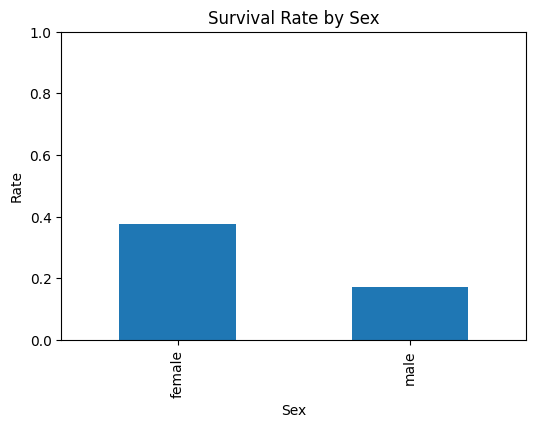

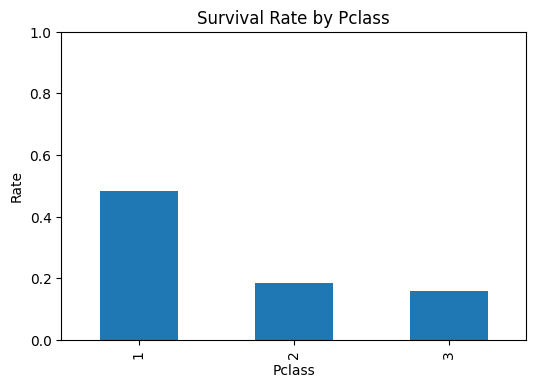

In [4]:

# Survival rate by Sex and Pclass
sex_rate = df.groupby('Sex')['Survived'].mean().sort_values(ascending=False)
pclass_rate = df.groupby('Pclass')['Survived'].mean()
bar_from_group(sex_rate, title="Survival Rate by Sex", ylabel="Rate", ylim01=True)
bar_from_group(pclass_rate, title="Survival Rate by Pclass", ylabel="Rate", ylim01=True)


## 3) Target & Features (safety: drop NaN target if present)

In [5]:

cols = ['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
data = df[cols].copy()
data['Alone'] = ((data['SibSp'].fillna(0) + data['Parch'].fillna(0)) == 0).astype(int)

data = data.dropna(subset=['Survived']).reset_index(drop=True)

y = data['Survived']
X = data.drop(columns=['Survived'])

num_features = ['Pclass','Age','SibSp','Parch','Fare']
cat_features = ['Sex','Embarked','Alone']


## 4) Preprocessing + Split — What & Why

In [6]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocess = ColumnTransformer([('num', numeric_transformer, num_features), ('cat', categorical_transformer, cat_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 5) Train & Evaluate — Metrics to report

In [7]:

model = Pipeline([('preprocess', preprocess), ('clf', LogisticRegression(max_iter=1000))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    'accuracy': round(accuracy_score(y_test, y_pred),3),
    'precision': round(precision_score(y_test, y_pred),3),
    'recall': round(recall_score(y_test, y_pred),3),
    'f1': round(f1_score(y_test, y_pred),3),
    'roc_auc': round(roc_auc_score(y_test, y_proba),3)
}
metrics


{'accuracy': 0.754,
 'precision': 0.5,
 'recall': 0.205,
 'f1': 0.29,
 'roc_auc': 0.682}

## 6) Diagnostics — Confusion Matrix & ROC Curve

In [8]:

from utils import confusion_df
confusion_df(y_test, y_pred)


,Pred 0,Pred 1
Actual 0,126,9
Actual 1,35,9


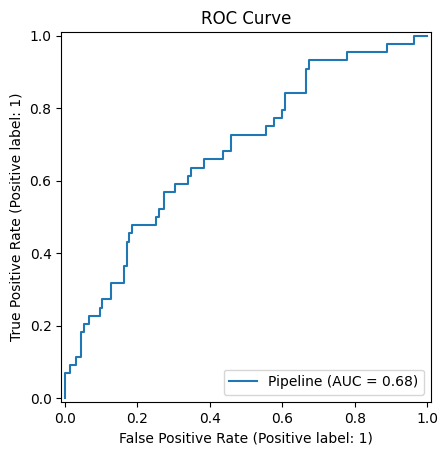

In [9]:

import matplotlib.pyplot as plt
try:
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC Curve'); plt.show()
except Exception as e:
    print("ROC curve not available in this sklearn version:", e)


## 7) Interpretation — Coefficients & Odds Ratios

In [10]:

ct = model.named_steps['preprocess']
ohe = ct.named_transformers_['cat'].named_steps['onehot']
num_names = num_features
cat_names = list(ohe.get_feature_names_out(cat_features))
all_feature_names = num_names + cat_names

coef = model.named_steps['clf'].coef_[0]
import pandas as pd, numpy as np
coef_df = pd.DataFrame({'feature': all_feature_names, 'coef': coef})
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df.sort_values('odds_ratio', ascending=False).head(12)


,feature,coef,odds_ratio
5,Sex_female,0.662794,1.940206
11,Alone_1,0.271758,1.312270
9,Embarked_S,0.229940,1.258525
4,Fare,0.136702,1.146486
3,Parch,-0.008935,0.991104
2,SibSp,-0.040388,0.960416
7,Embarked_C,-0.048222,0.952922
1,Age,-0.164287,0.848499
8,Embarked_Q,-0.182882,0.832866
10,Alone_0,-0.272923,0.761151


## ✅ What we infer
- We check **accuracy + precision/recall/F1** (especially if class imbalance exists) and **ROC‑AUC**.
- Confusion matrix shows failure modes.
- Coefficients/odds help communicate drivers of survival.